In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [22]:
# Set random seed
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [23]:
# Hyperparameters
batch_size = 32
learning_rate =0.001
num_epochs = 15
num_classes = 2
patience = 10  # Early stopping patience

In [24]:
# Load dataset
train_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/train"
val_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/val"
test_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/test"

In [25]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [26]:
# Load training, validation, and test images with transforms
train_data = datasets.ImageFolder(root=train_path, transform=transform)
val_data = datasets.ImageFolder(root=val_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)

# Create loaders to read the data in batches
# Shuffle training data to mix it up each time
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Don't shuffle validation and test data
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [27]:
# Set the model name
model_name = "vit_small_patch16_224"

# Load a pretrained ViT model
model = create_model(model_name, pretrained=True)

# Replace the classifier head with a custom one matching the number of classes
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, num_classes)
)

# Move the model to GPU (if available) or CPU
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set up optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Initialize lists to track training and validation metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Setup for early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Start training loop
for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0
    correct, total = 0, 0
    
    # Loop through all training batches
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Apply CutMix: mix images and their labels
        lam = np.random.beta(0.8, 0.8)
        rand_index = torch.randperm(images.size()[0]).to(device)
        target_a, target_b = labels, labels[rand_index]
        images = lam * images + (1 - lam) * images[rand_index]

        # Forward pass and mixed loss calculation
        outputs = model(images)
        loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
        loss.backward()
        optimizer.step()

        # Track training metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Compute average loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()  # switch to evaluation mode
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():  # no gradient calculation needed
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Compute average validation metrics
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print training progress
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Early stopping: save model if validation loss improves
    model_path = f'best_model_{model_name}.pth'
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    # Step the scheduler to update the learning rate
    scheduler.step()

# Load the best model (based on validation loss) for testing
model.load_state_dict(torch.load(model_path))
model.eval()

# Evaluate on the test set
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Compute and print final test loss and accuracy
test_loss /= len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:57<00:00,  2.34it/s]


Epoch 1/15, Loss: 0.4457, Accuracy: 68.9647, Val Loss: 0.2295, Val Accuracy: 92.2321


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:53<00:00,  2.43it/s]


Epoch 2/15, Loss: 0.3471, Accuracy: 74.5392, Val Loss: 0.1628, Val Accuracy: 94.9107


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:53<00:00,  2.43it/s]


Epoch 3/15, Loss: 0.3169, Accuracy: 74.3345, Val Loss: 0.1435, Val Accuracy: 94.3750


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:53<00:00,  2.42it/s]


Epoch 4/15, Loss: 0.3144, Accuracy: 76.3709, Val Loss: 0.1613, Val Accuracy: 94.0179


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:55<00:00,  2.37it/s]


Epoch 5/15, Loss: 0.3265, Accuracy: 77.3720, Val Loss: 0.1483, Val Accuracy: 95.2679


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:50<00:00,  2.50it/s]


Epoch 6/15, Loss: 0.3169, Accuracy: 77.4516, Val Loss: 0.1588, Val Accuracy: 94.0179


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:52<00:00,  2.44it/s]


Epoch 7/15, Loss: 0.3106, Accuracy: 75.0967, Val Loss: 0.1393, Val Accuracy: 95.8929


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:54<00:00,  2.40it/s]


Epoch 8/15, Loss: 0.3003, Accuracy: 77.2924, Val Loss: 0.1630, Val Accuracy: 95.3571


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:57<00:00,  2.35it/s]


Epoch 9/15, Loss: 0.3020, Accuracy: 75.0626, Val Loss: 0.1675, Val Accuracy: 96.4286


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:56<00:00,  2.36it/s]


Epoch 10/15, Loss: 0.2940, Accuracy: 76.6553, Val Loss: 0.1618, Val Accuracy: 96.4286


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:50<00:00,  2.50it/s]


Epoch 11/15, Loss: 0.3015, Accuracy: 76.1320, Val Loss: 0.1699, Val Accuracy: 95.2679


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:52<00:00,  2.44it/s]


Epoch 12/15, Loss: 0.2800, Accuracy: 77.8498, Val Loss: 0.1630, Val Accuracy: 95.4464


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:57<00:00,  2.34it/s]


Epoch 13/15, Loss: 0.2808, Accuracy: 75.6883, Val Loss: 0.1653, Val Accuracy: 95.3571


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:52<00:00,  2.45it/s]


Epoch 14/15, Loss: 0.2958, Accuracy: 75.6428, Val Loss: 0.1633, Val Accuracy: 95.5357


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [01:54<00:00,  2.39it/s]


Epoch 15/15, Loss: 0.2872, Accuracy: 75.9954, Val Loss: 0.1662, Val Accuracy: 95.8000
Test Loss: 0.1521, Test Accuracy: 95.5752


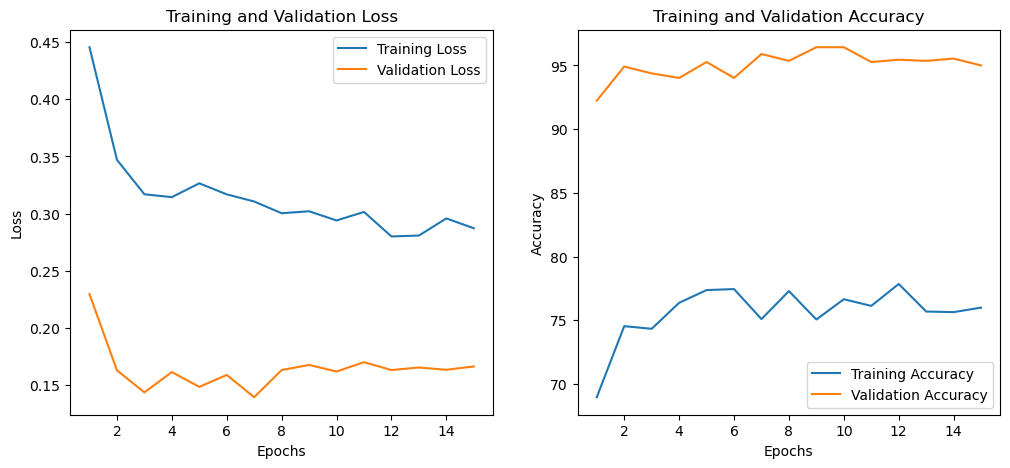

In [28]:
# Plot Training and Validation Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
axes[0].plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy plot
axes[1].plot(range(1, len(train_accs)+1), train_accs, label='Training Accuracy')
axes[1].plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [32]:
test_labels, test_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        test_labels.extend(labels.cpu().numpy())  # Store true labels
        test_preds.extend(predicted.cpu().numpy())  # Store predicted labels

In [33]:
test_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/test"
test_data = datasets.ImageFolder(root=test_path, transform=transform)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Load best model for testing
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.1521, Test Accuracy: 95.5752


In [34]:
import matplotlib.pyplot as plt

# Store misclassified and correctly classified images
test_images, test_labels, test_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Move images to CPU for visualization
        test_images.extend(images.cpu())  
        test_labels.extend(labels.cpu().numpy())  
        test_preds.extend(predicted.cpu().numpy())  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

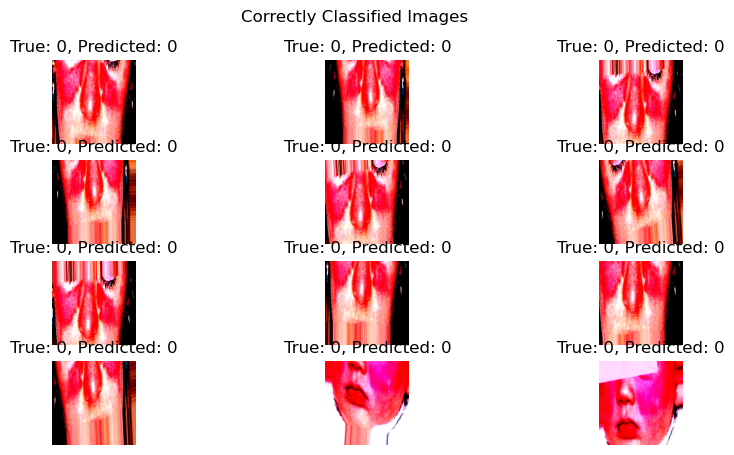

In [35]:
# Find correctly classified images
correct_indices = [i for i in range(len(test_labels)) if test_labels[i] == test_preds[i]]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(correct_indices[:12]):  # Show first 6 correctly classified images
    plt.subplot(4, 3, i+1)
    plt.imshow(test_images[idx].permute(1, 2, 0))  # Convert tensor to image format
    plt.title(f"True: {test_labels[idx]}, Predicted: {test_preds[idx]}")
    plt.axis("off")
plt.suptitle("Correctly Classified Images")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

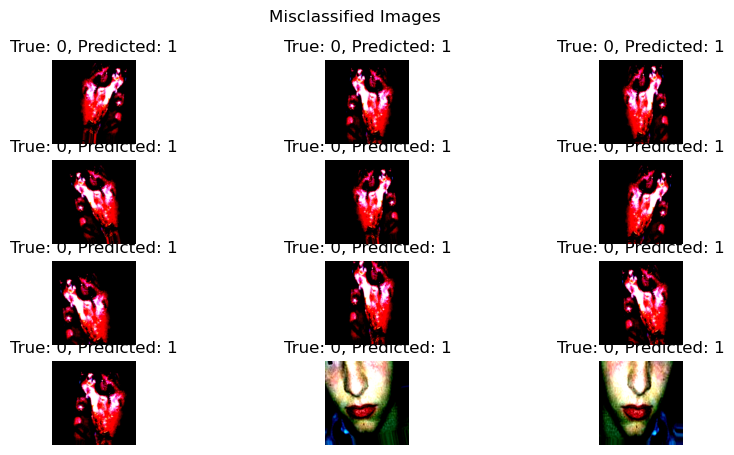

In [36]:
# Find misclassified images
incorrect_indices = [i for i in range(len(test_labels)) if test_labels[i] != test_preds[i]]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect_indices[:12]):  # Show first 6 misclassified images
    plt.subplot(4, 3, i+1)
    plt.imshow(test_images[idx].permute(1, 2, 0))  # Convert tensor to image format
    plt.title(f"True: {test_labels[idx]}, Predicted: {test_preds[idx]}")
    plt.axis("off")
plt.suptitle("Misclassified Images")
plt.show()


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch


Validation Accuracy: 0.9589, Validation Loss: 0.1393


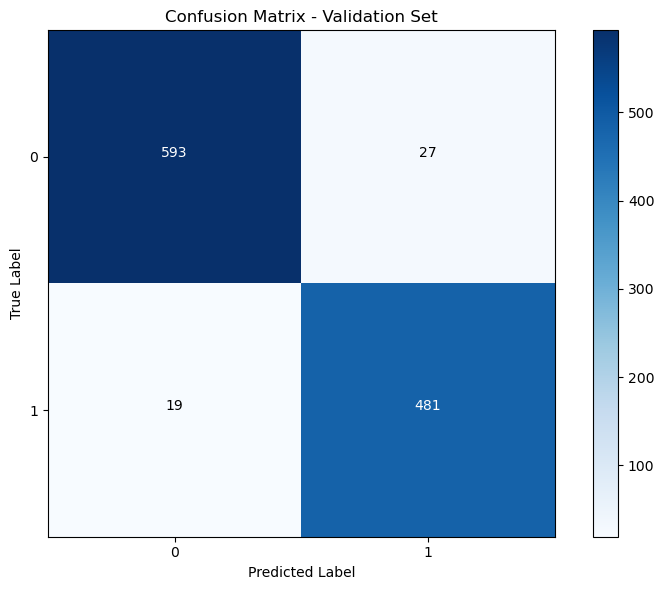


Classification Report - Validation Set:
              precision    recall  f1-score   support

           0     0.9690    0.9565    0.9627       620
           1     0.9469    0.9620    0.9544       500

    accuracy                         0.9589      1120
   macro avg     0.9579    0.9592    0.9585      1120
weighted avg     0.9591    0.9589    0.9590      1120


Test Accuracy: 0.9558, Test Loss: 0.1521


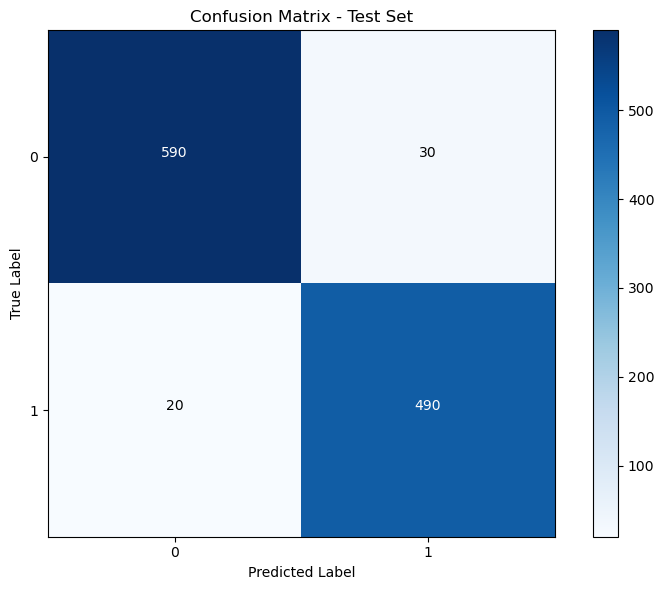


Classification Report - Test Set:
              precision    recall  f1-score   support

           0     0.9672    0.9506    0.9593       620
           1     0.9423    0.9608    0.9515       510

    accuracy                         0.9558      1130
   macro avg     0.9548    0.9552    0.9554      1130
weighted avg     0.9560    0.9548    0.9558      1130



In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, data_loader, criterion, dataset_name="Validation"):
    """Evaluate the model and return true labels, predictions, and accuracy."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        loss_total = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        accuracy = correct_preds / total_preds
        print(f"\n{dataset_name} Accuracy: {accuracy:.4f}, {dataset_name} Loss: {loss_total / len(data_loader):.4f}")

    return all_labels, all_preds

def plot_confusion_matrix(y_true, y_pred, dataset_name="Test"):
    """Plot a non-normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]  # Automatically detect number of classes

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {dataset_name} Set')
    plt.colorbar()

    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Display raw count values inside the confusion matrix
    thresh = cm.max() / 2.  # Threshold for text color contrast
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}",  # Display raw count (integer)
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def print_classification_report(y_true, y_pred, dataset_name="Test"):
    """Print classification report with precision, recall, and F1-score."""
    print(f"\nClassification Report - {dataset_name} Set:")
    print(classification_report(y_true, y_pred, digits=4))

# Evaluate on validation set
val_labels, val_preds = evaluate_model(model, val_loader, criterion, "Validation")
plot_confusion_matrix(val_labels, val_preds, "Validation")
print_classification_report(val_labels, val_preds, "Validation")

# Evaluate on test set
test_labels, test_preds = evaluate_model(model, test_loader, criterion, "Test")
plot_confusion_matrix(test_labels, test_preds, "Test")
print_classification_report(test_labels, test_preds, "Test")


In [39]:
test_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset/test"
test_data = datasets.ImageFolder(root=test_path, transform=transform)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Load best model for testing
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.2298, Test Accuracy: 91.0714



Validation Accuracy: 0.9589, Validation Loss: 0.1393


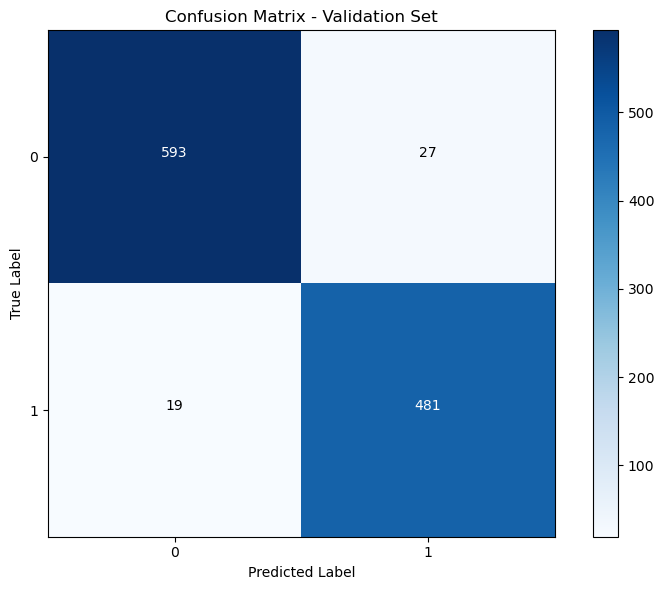


Classification Report - Validation Set:
              precision    recall  f1-score   support

           0     0.9690    0.9565    0.9627       620
           1     0.9469    0.9620    0.9544       500

    accuracy                         0.9589      1120
   macro avg     0.9579    0.9592    0.9585      1120
weighted avg     0.9591    0.9589    0.9590      1120


Test Accuracy: 0.9107, Test Loss: 0.2298


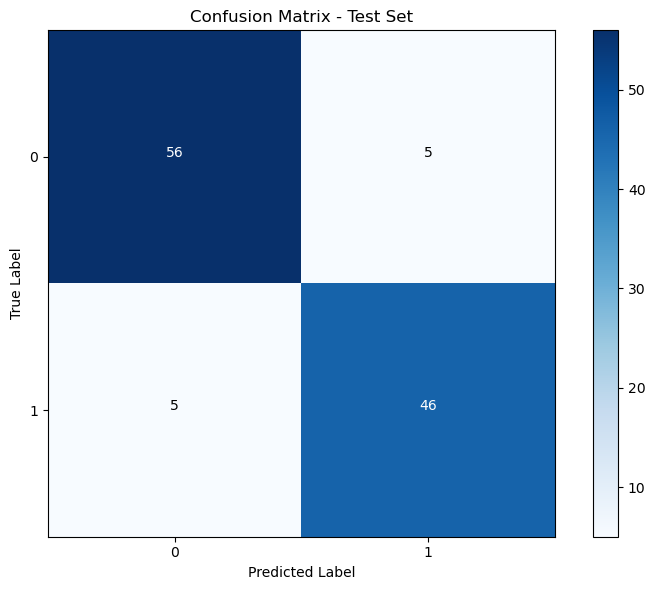


Classification Report - Test Set:
              precision    recall  f1-score   support

           0     0.9180    0.9180    0.9180        62
           1     0.9020    0.9020    0.9020        51

    accuracy                         0.9107       113
   macro avg     0.9100    0.9100    0.9100       113
weighted avg     0.9107    0.9107    0.9107       113



In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, dataset_name="Test"):
    """Plot a non-normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]  # Automatically detect number of classes

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {dataset_name} Set')
    plt.colorbar()

    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Display raw count values inside the confusion matrix
    thresh = cm.max() / 2.  # Threshold for text color contrast
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}",  # Display raw count (integer)
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def print_classification_report(y_true, y_pred, dataset_name="Test"):
    """Print classification report with precision, recall, and F1-score."""
    print(f"\nClassification Report - {dataset_name} Set:")
    print(classification_report(y_true, y_pred, digits=4))

# Evaluate on test set
test_labels, test_preds = evaluate_model(model, test_loader, criterion, "Test")
plot_confusion_matrix(test_labels, test_preds, "Test")
print_classification_report(test_labels, test_preds, "Test")


In [46]:
import os
from PIL import Image
import imagehash
from collections import defaultdict

# Define your dataset paths
base_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3"
splits = ['train', 'test']

# Store image hashes and their locations
hash_dict = defaultdict(list)

# Loop through each dataset split
for split in splits:
    for label in ['BMR', 'RASH']:
        folder = os.path.join(base_path, split, label)
        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            try:
                img = Image.open(fpath).convert('RGB')  # Ensure it's in the same mode
                hash_val = imagehash.phash(img)
                hash_dict[str(hash_val)].append((split, label, fname))
            except Exception as e:
                print(f"Error reading {fpath}: {e}")

# Now check for duplicates across splits
print("\n🔍 Possible duplicates across splits:")
for hval, entries in hash_dict.items():
    if len(entries) > 1:
        # Check if these entries are from different splits
        unique_splits = set([e[0] for e in entries])
        if len(unique_splits) > 1:
            print(f"Hash: {hval} - Found in:")
            for e in entries:
                print(f"  ➤ {e[0]}/{e[1]}/{e[2]}")



🔍 Possible duplicates across splits:
